## In this use-case, we demonstrate the capability of the CCP-tool to learn and predict volumetric Projection Density data, derived at 200 cubic micrometer resolution from wild-type tract tracing experiments of the Allen Mouse Brain Connectivity Atlas, using volumetric gene expression data, derived at the same resolution from the Allen Mouse Brain Atlas ISH coronal experiments.


## Beginnings:
### Load all necessary ingredients from the storage

## Step 0: 
### Import the libraries / initialize the pipeline

In [1]:
import os
from subprocess import call
import pickle as pk
from IPython.display import clear_output
current_dir = os.listdir('./')
for path in os.listdir('../25 3 2019/'):
    if os.path.islink(path) is not True and path not in current_dir:
        call(['ln','-s','../25 3 2019/'+ path, path])        
from cfg import *
os.chdir('../CCP_Collab_Backup_2/')
import PrimaryLibrary as PL
imp.reload(PL)
import MorphologyLibrary as MLab
imp.reload(MLab)
import Allen_API_Library as API
imp.reload(API)
MesoPred = PL.MesoconnectomePredictor()

importing Jupyter notebook from Allen_API_Library.ipynb
importing Jupyter notebook from Allen_API_Library.ipynb


## Step I: Initialization 
### Load and Preprocess Volumetric data

In [4]:
from scipy.io import loadmat
import subprocess

# removing unncessary files for memory conservation
refAtlas_path = 'refAtlas.mat/home/storage/AllenBrainAtlasToolboxVersion2/AllenBrainAtlasToolboxPrime/atlasData/refAtlas.mat'
Ref = loadmat(refAtlas_path)
VoxelDict = loadmat('ExpEnergy.mat')
subprocess.call(['rm','*.mat'])

print 'Downloading/storing volumetric gene expression data'
VolGeneExp,Non_zero_voxels,vox_genes,vox_gene_ids,dims = API.Read_v2_Data(VoxelDict,Ref)
pk.dump(VolGeneExp, open('VolGeneExp.pkl','wb'))
print 'Gene expression parsing has been complete'

print 'Downloading/storing wild-type projection density data'
WTMeta, VolProjDensity = API.ReadConnectivityData()
ProjPerExp = h5py.File('ProjPerExp.hdf5','r')['dataset1'][()]
print 'Projection density parsing has been completed'
 
# In this step we downsample the Projection Density data to 200 cubic micrometers, 
# in order to be in the same scale as the gene expression data
print 'downsampling the projection density data down to 200 microns'
VolProjDensity_200 = PL.Resample_Voxels(VolProjDensity, resolution = 200)

InputData = [VolGeneExp,VolProjDensity_200]
# In this step, the data are being z-scored per feature (gene, projection from source)
Data_Modality, Data_Modality_sc = PL.VolPreProcessing(InputData,Non_zero_voxels)

print Data_Modality[0].shape, Data_Modality[1].shape,Data_Modality_sc[0].shape, Data_Modality_sc[1].shape 

Downloading/storing volumetric gene expression data
Gene expression parsing has been complete
Downloading/storing wild-type projection density data
Projection density parsing has been completed
downsampling the projection density data down to 200 microns
(132, 80, 114, 498)
upsampling has been completed!
Time elapsed: 0.963355183601
(4104, 49742) (498, 49742) (4104, 49742) (498, 49742)


## Step II: Sparse decomposition
### Using Dictionary Learning and Sparse Coding (DLSC) to decompose both data modalities into basis vectors with sparse representations of genes and projections from sources

#### To speed-up the demonstration, the resulting dictionaries are being loaded through pickle files.   
#### In case that the full iteration of the process is desired, click on the cell below and change its form from "Raw NBConvert" to "Code" 

In [12]:
from sklearn.decomposition import MiniBatchDictionaryLearning
dlsc  = MiniBatchDictionaryLearning(n_components = 200, alpha = 1.0, 
                           fit_algorithm = 'cd', transform_algorithm = 'lasso_cd',
                           random_state = 123)
                                          

print(Data_Modality_sc[0].shape,Data_Modality_sc[1].shape)

X = np.asfortranarray(Data_Modality_sc[0])
dlsc.fit(X)
G_Atoms = dlsc.components_
G_Code  = dlsc.transform(X)
                                          
pk.dump(G_Atoms,open('Atoms_4_GeneVol.pkl','wb'))
pk.dump(G_Code,open('Code_4_GeneVol.pkl','wb'))      

X2 = np.asfortranarray(Data_Modality_sc[1])
dlsc.fit(X2)
P_Atoms = dlsc.components_
P_Code  = dlsc.transform(X2)
                                          
pk.dump(P_Atoms,open('Atoms_4_ProjVol.pkl','wb'))
pk.dump(P_Code,open('Code_4_ProjVol.pkl','wb'))       


((4104, 49742), (498, 49742))


In [10]:
G_Atoms = pk.load(open('Atoms_4_GeneVol.pkl','rb'))
P_Atoms = pk.load(open('Atoms_4_ProjVol.pkl','rb'))
G_Code = pk.load(open('Code_4_GeneVol.pkl','rb'))
P_Code = pk.load(open('Code_4_ProjVol.pkl','rb'))


## Part III: Two-fold assessment of DLSC: 
### 1) Evaluate the reconstuction error of the method for both modalities  
### 2) Use the gene dictionaries to predict the projection patterns with the CCP tool and assess the generalization performances of all models

Prediction from dictionary r2 score (total): 0.0057812751999


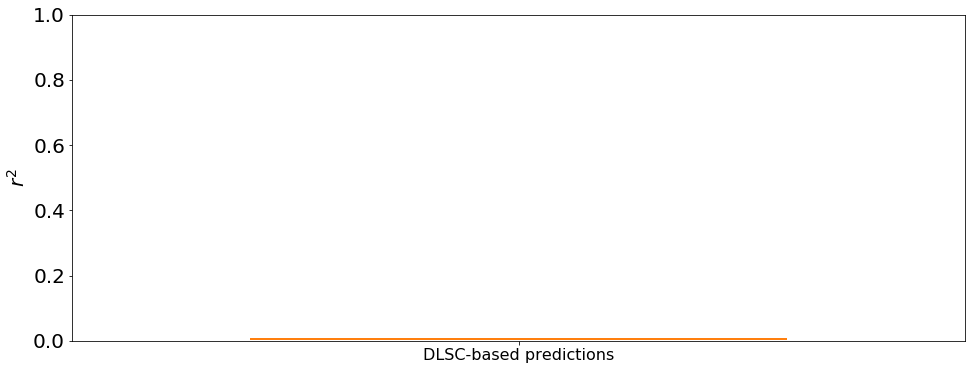

In [11]:
# Step 1: Reconstruct the original volumetric arrays
RecMod1 = np.matmul(G_Code,G_Atoms)
RecMod2 = np.matmul(P_Code,P_Atoms)

# Step 3: estimate the r2 of explained variance by the reconstructed gene expression and projection density data
#         to the original data
print 'Gene reconstruction r2 score: {}'.format(metrics.r2_score(Data_Modality_sc[0],RecMod1))
print 'Projection reconstruction r2 score: {}'.format(metrics.r2_score(Data_Modality_sc[1],RecMod2))

# Step 4: predict projection density from mixed dictionaries
Y_dict_proj, r2_dict_proj, mdls_dict_proj = PL.GeneralizedCCP(G_Atoms.T,Data_Modality_sc[1].T, style = 'all', n_jobs = 1)
print 'Prediction from dictionary r2 score (total): {}'.format(metrics.r2_score(Data_Modality_sc[1].T,Y_dict_proj))

# Step 5: plot the results
r2_proj_dict = metrics.r2_score(Data_Modality_sc[1].T,Y_dict_proj, multioutput = 'raw_values')
input_for_plot = [r2_proj_dict]
x_ticks = ['DLSC-based predictions']
y_ticks = np.arange(0,1.1,0.2)
PL.Custom_Boxplot(input_for_plot,x_ticks = x_ticks, y_ticks = y_ticks, y_label = r'$r^2$', \
                  title = 'r2 distribution across injections')